In [13]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import t

# Generate the data according to Section 5.1 of "Bayesian Learning via SGLD."
N = 500 # The number of data points; we reference this frequently later.
sigma1_sq = 10
sigma2_sq = 1
sigmax_sq = 2
theta1 = 0
theta2 = 1

# Generate the data X. The np.random.normal(...) requires STD (not VAR).
X = np.zeros(N)
for i in range(N):
    u = np.random.random()
    if (u < 0.5):
        X[i] = np.random.normal(theta1, np.sqrt(sigmax_sq))
    else:
        X[i] = np.random.normal(theta1+theta2, np.sqrt(sigmax_sq))

In [14]:
def log_f(theta, X):
    """
    The function 'f' is the posterior:
    
        f(\theta) \propto p(\theta) * \prod_{i=1}^N p(x_i | \theta)
    
    This method returns the *log* of f(\theta), for obvious reasons.
    X is assumed to be of shape (n,) so we reshape it into (n,1) for vectorization.
    We use [0,0] since we get a float in two lists, [[x]], so calling [0,0] gets x.
    """
    scale = N / float(len(X))
    
    inverse_covariance = np.array([[0.1,0],[0,1]])
    prior_constant = 1.0 / (2*np.pi*np.sqrt(10))
    prior = np.log(prior_constant) - 0.5*(theta.T).dot(inverse_covariance).dot(theta)
    
    X_all = X.reshape((len(X),1))
    ll_constant = (1.0 / (4*np.sqrt(np.pi)))
    L = ll_constant * (np.exp(-0.25*(X_all-theta[0])**2) + np.exp(-0.25*(X_all-(theta[0]+theta[1]))**2))
    log_likelihood = np.sum(np.log(L)) * scale
    
    assert not np.isnan(prior + log_likelihood)
    return (prior + log_likelihood)[0,0]
    
    
def grad_f(theta, X):
    """ Computes gradient of log_f by finite differences. X is (usually) a mini-batch. """
    eps = 0.00001
    base1 = np.array([[eps],[0]])
    base2 = np.array([[0],[eps]])
    term1 = log_f(theta+base1, X) - log_f(theta-base1, X)
    term2 = log_f(theta+base2, X) - log_f(theta-base2, X)
    return np.array([[term1],[term2]])/(2*eps)
    
 
def get_delta(theta_c, theta_p, X):
    """
    Compute the delta term, so we use min{1, exp(\Delta')} for standard MCMC.
    
    theta_c is the *current* theta that we may "leave" (old theta)
    theta_p is the *proposed* theta that we might accept (new theta)
    """
    loss_old = log_f(theta_c, X)
    loss_new = log_f(theta_p, X)
    assert not np.isnan(loss_new - loss_old)
    return loss_new - loss_old


def get_noise(eps):
    """ Returns a 2-D multivariate normal vector with covariance matrix = diag(eps,eps). """
    return (np.random.multivariate_normal(np.array([0,0]), eps*np.eye(2))).reshape((2,1))


def log_f_prior(theta):
    """
    Returns log p(\theta), the prior. Remember, it's returning LOGS. Don't take logs again! 
    This is only used for the adaptive sampling method's hypothesis testing.
    """
    cov_inv = np.array([[0.1,0],[0,1]])
    return np.log(1.0/(2*np.pi*np.sqrt(10))) - 0.5*(theta.T).dot(cov_inv).dot(theta)
        
        
def approximate_mh_test(theta_c, theta_p, m1, X, mu_0, eps_tolerance):
    """
    Implements the adaptive sampling method. Each time we call this, we shuffle the data.
    
    theta_c is the current \theta
    theta_p is the proposed \theta
    m1 is the starting minibatch size
    X is the full data matrix
    mu_0 is equation 2 from "Cutting the MH" paper, pre-computed
    eps_tolerance is for deciding whether delta is small enough
    
    Returns ('accept', 'size'), where 'accept' is a boolean to indicate if we accept or not,
        while 'size' is the size of the mini-batch we sampled (generally a multiple of m).
    """
    
    accept = False
    done = False
    first_iteration = True
    n = 0
    m2 = m1 # We'll increment by the same amount as 'm1', the starting size.
    
    # Shuffle at beginning so we can do X_mini = X[:n]
    index = np.random.permutation(N)
    X = X[index]

    while not done:
        
        # Draw mini-batch without replacement, but keep using same indices we've used.
        # Note that we can have a special case for the first minibatch.
        if first_iteration:
            size = np.min([m1, N])
            first_iteration = False
        else:
            size = np.min([m2, N-n])
        n = n + size
        X_mini = (X[:n]).reshape((n,1)) # To enable broadcasting
        
        # Now compute ell_bar and ell_bar_squared, which rely on the data.
        numerator   = np.exp( -0.25*(X_mini-theta_p[0])**2 ) + np.exp( -0.25*(X_mini-(theta_p[0]+theta_p[1]))**2 )
        denominator = np.exp( -0.25*(X_mini-theta_c[0])**2 ) + np.exp( -0.25*(X_mini-(theta_c[0]+theta_c[1]))**2 )
        log_terms = np.log( numerator / denominator )
        ell_bar = (1.0/n) * np.sum(log_terms)
        ell_bar_squared = (1.0/n) * np.sum(log_terms**2) # Squaring individual terms!
        
        # Let's just be safe and check for NaNs.
        assert not np.isnan(np.sum(numerator))
        assert not np.isnan(np.sum(denominator))
        assert not np.isnan(ell_bar)
        assert not np.isnan(ell_bar_squared)
        
        # Now we have the information needed to compute s_l, s, |t|, and delta.
        # Note that if n == N, we can exit since we know delta should be 0. We have all the data.
        if (n == N):
            delta = 0
        else:           
            s_l = np.sqrt((ell_bar_squared - (ell_bar**2)) * (float(n)/(n-1)))
            s = (s_l / np.sqrt(n)) * np.sqrt(1 - (float(n-1)/(N-1)))
            test_statistic = np.abs((ell_bar - mu_0) / s)
            delta = 1 - t.cdf(test_statistic, n-1)
            assert not np.isnan(delta)
            assert not np.isnan(s)
        
        # Finally, we can test if our hypothesis is good enough.
        if (delta < eps_tolerance):
            if (ell_bar > mu_0):
                accept = True
            done = True
  
    return (accept,n)

In [20]:
############################
# STANDARD FULL-BATCH MCMC #
############################
num_passes = 10000
rw_eps = 0.02
theta = np.array([[0.5],[0]])
all_1 = theta # Our vector of theta values

for T in range(1,num_passes):
        
    # Standard MH test. Note that it's just min{1, exp(\Delta')}.
    theta_new = theta + get_noise(rw_eps)        
    delta_real = get_delta(theta, theta_new, X)
    test = np.min([1, np.exp(delta_real)])
    u = np.random.random()
    
    # Perform test of acceptance. Even if we reject, we add current theta to all_1.
    if (u < test):
        theta = theta_new
    all_1 = np.concatenate((all_1,theta), axis=1)
        
print("\nDone with the standard minibatch MCMC test.\n")


#########################################
# STOCHASTIC GRADIENT LANGEVIN DYNAMICS #
#########################################
num_passes = 30000
theta = np.array([[0.5],[0]])
all_2 = theta
mb_size = 30

# a and b are based on parameter values similar to those from the SGLD paper.
a = 0.06
b = 30

for T in range(1,num_passes): 

    # Step size according to the SGLD paper.
    eps = a*((b + T) ** (-0.55))
    
    # Get a minibatch, then compute the gradient, then the corresponding \theta updates.
    X_mini = X[np.random.choice(N, mb_size, replace=False)]
    gradient = grad_f(theta, X_mini)
    theta = theta + (eps/2.0)*gradient + get_noise(eps)
    
    # Add theta to all_2 and repeat.
    assert not np.isnan(np.sum(theta))
    all_2 = np.concatenate((all_2,theta), axis=1)
    
print("\nDone with Stochastic Gradient Langevin Dymamics.\n")


############################
# MODIFIED METHOD #
############################

num_passes = 30000
theta = np.array([[0.5],[0]])
all_3 = theta
mb_size = 30

# a and b are based on parameter values similar to those from the SGLD paper.
a = 0.06
b = 30

for T in range(1,num_passes): 

    # Step size according to the SGLD paper.
    eps = a*((b + T) ** (-0.5))
    
    # Get a minibatch, then compute the gradient, then the corresponding \theta updates.
    X_mini = X[np.random.choice(N, mb_size, replace=False)]
    gradient = grad_f(theta, X_mini)
    theta = theta + (eps/2.0)*gradient + (T**(-0.55))*get_noise(eps)
    
    # Add theta to all_2 and repeat.
    assert not np.isnan(np.sum(theta))
    all_3 = np.concatenate((all_3,theta), axis=1)
    
print("\nDone with Modified method.\n")


Done with the standard minibatch MCMC test.


Done with Stochastic Gradient Langevin Dymamics.


Done with Modified method.



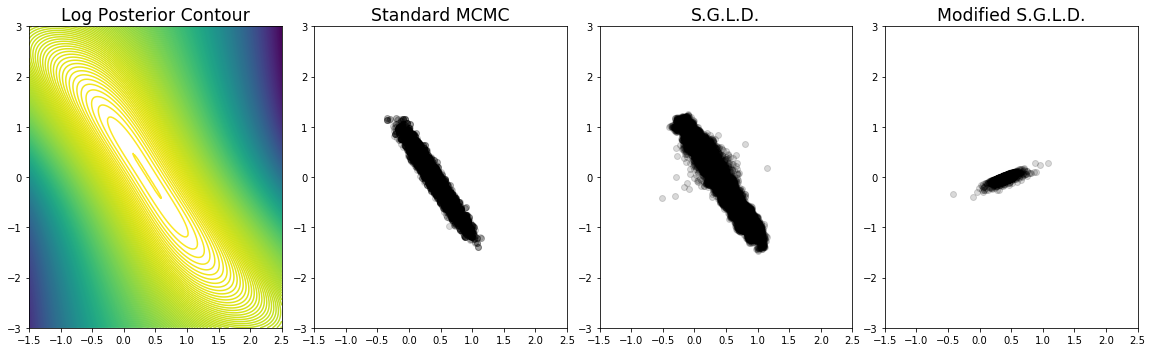

In [23]:
# Let's form the plot. This will be one figure with four sub-figures.
mymap2 = plt.get_cmap("Greys")
m_c2 = mymap2(400)
fig, axarr = plt.subplots(1,4, figsize=(16, 5))
(xlim1,xlim2) = (-1.5,2.5)
(ylim1,ylim2) = (-3,3)

# A contour plot of what the posterior really looks like.
axarr[0].set_title("Log Posterior Contour", size="xx-large")
K = 200
xlist = np.linspace(-1.5,2.5,num=K)
ylist = np.linspace(-3,3,num=K)
X_a,Y_a = np.meshgrid(xlist, ylist)
Z_a = np.zeros((K,K))
for i in range(K):
    for j in range(K):
        theta = np.array( [[X_a[i,j]],[Y_a[i,j]]] )
        Z_a[i,j] = log_f(theta, X)        
axarr[0].contour(X_a,Y_a,Z_a,300)

# The standard MCMC method
axarr[1].set_title("Standard MCMC", size="xx-large")
axarr[1].scatter(all_1[0], all_1[1], color = m_c2, alpha=0.15)
axarr[1].set_xlim([xlim1,xlim2])
axarr[1].set_ylim([ylim1,ylim2])

# Stochastic Gradient Langevin Dynamics
axarr[2].set_title("S.G.L.D.", size="xx-large")
axarr[2].scatter(all_2[0], all_2[1], color = m_c2, alpha=0.15)
axarr[2].set_xlim([xlim1,xlim2])
axarr[2].set_ylim([ylim1,ylim2])

# The adaptive sampling method
axarr[3].set_title("Modified S.G.L.D.", size="xx-large")
axarr[3].scatter(all_3[0], all_3[1], color = m_c2, alpha=0.15)
axarr[3].set_xlim([xlim1,xlim2])
axarr[3].set_ylim([ylim1,ylim2])


plt.tight_layout()
plt.savefig('comparision.png', dpi=200)